In [ ]:
!pip install jcopml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import missingno as msno
warnings.simplefilter(action="ignore", category=FutureWarning)

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [ ]:
df = pd.read_csv('taxi_fare.csv', parse_dates= ['pickup_datetime'])
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0
...,...,...,...,...,...,...,...
18914,22.5,2013-06-02 01:13:00,-73.997090,40.720635,-73.971983,40.794597,2.0
18915,5.5,2014-10-15 14:47:00,-73.979980,40.751825,-73.973952,40.759965,1.0
18916,6.5,2015-06-28 13:00:47,-73.982315,40.762691,-73.993202,40.767578,1.0
18917,5.3,2011-10-28 17:48:45,-74.001457,40.739338,-73.993607,40.751885,1.0


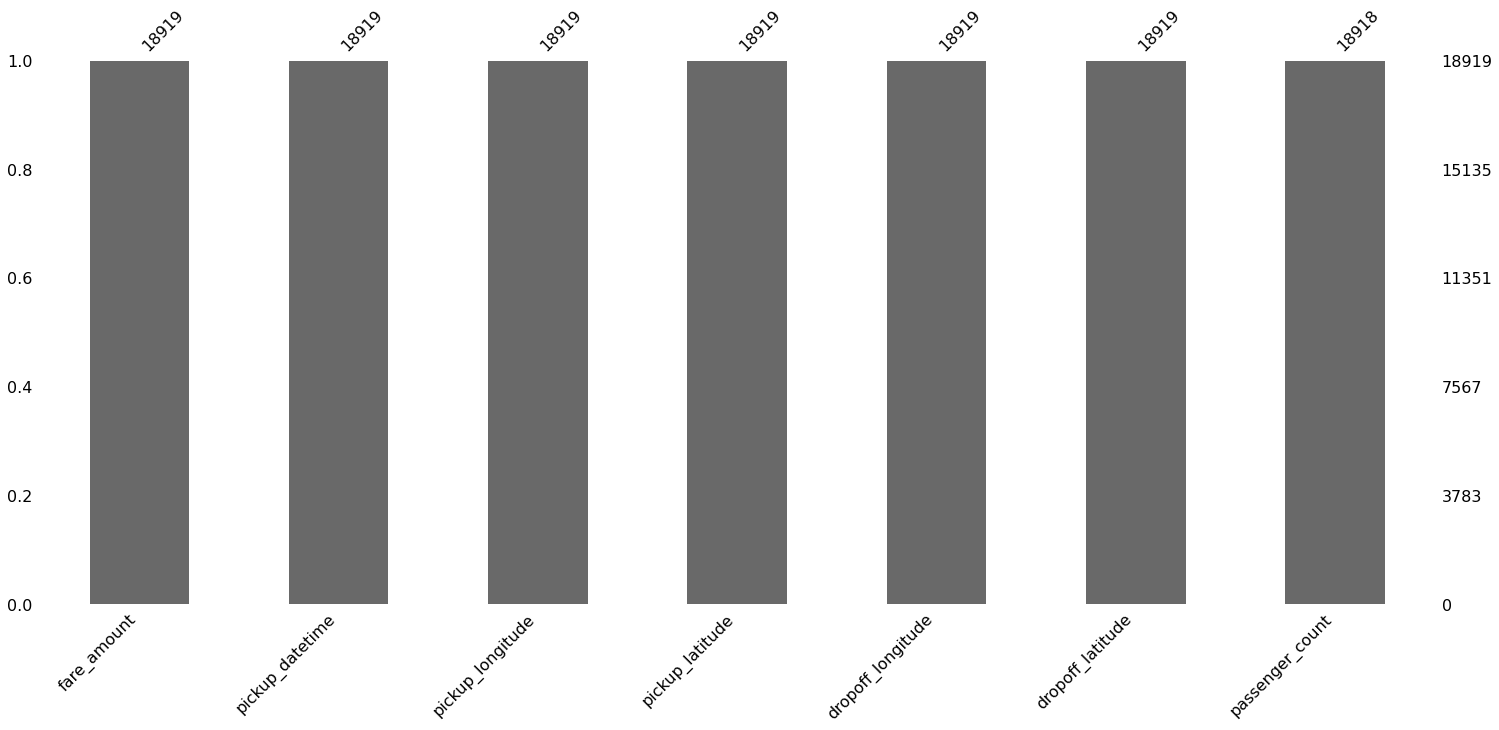

In [ ]:
msno.bar(df)

,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


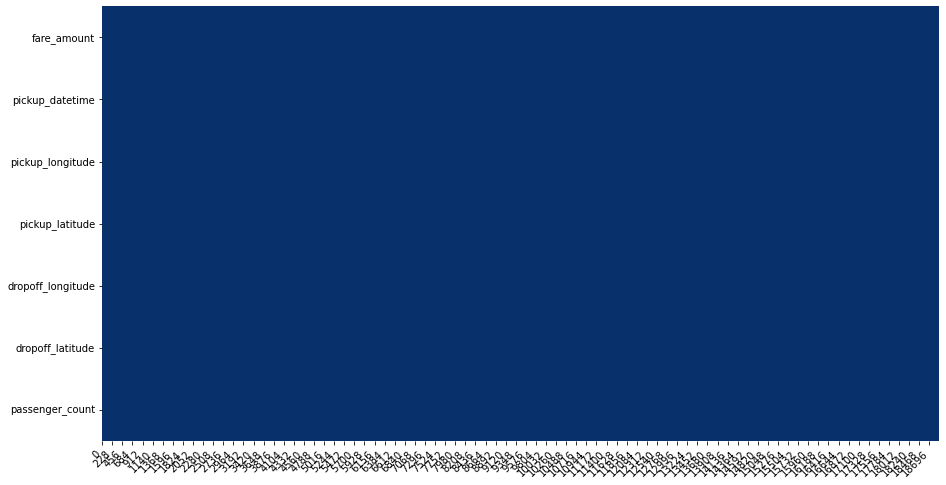

In [ ]:
plot_missing_value(df, return_df=True)

In [ ]:
df.dropna(inplace=True)

### Extract Time Feature

In [ ]:
pickup_dt = df.pickup_datetime.dt

In [ ]:
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


### Extract Distance Feature

In [ ]:
df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


### Dataset Splitting

In [ ]:
X = df.drop(columns='fare_amount')
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [ ]:
gsp.linreg_params

{'algo__fit_intercept': [True, False]}

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'year', 'distance']),
                                  ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour']),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.717616880856931 0.7458231887208437


### Evaluation

#### Actual vs Prediction Plot

In [ ]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

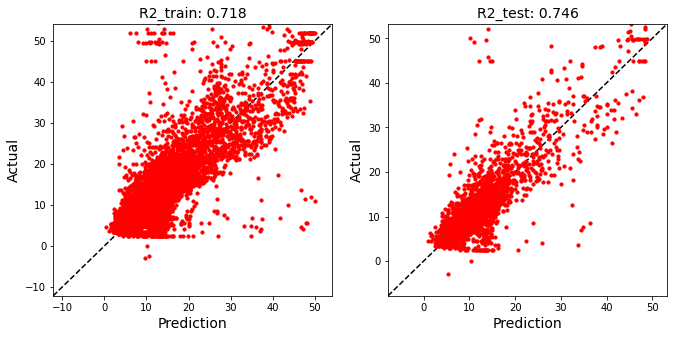

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

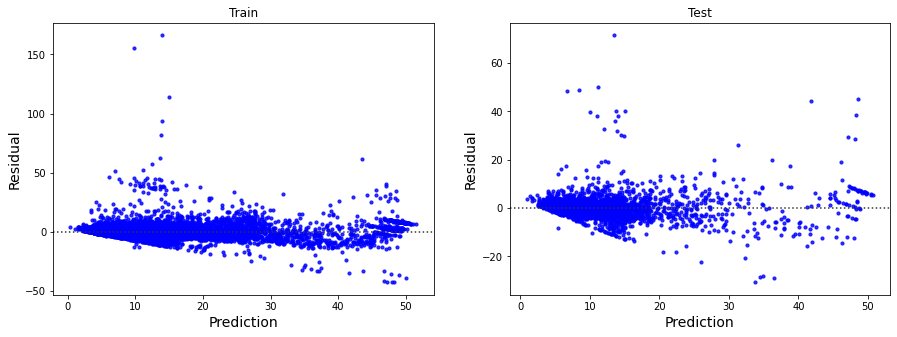

In [ ]:
plot_residual(X_train, y_train, X_test, y_test, model)